In [1]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter, Augmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self.X_train.shape: (896, 945)
self.X_test.shape: (3582, 945)
# unique labels (train): [0 1 2 3 4 5 6 7]
# unique labels (test): [0 1 2 3 4 5 6 7]


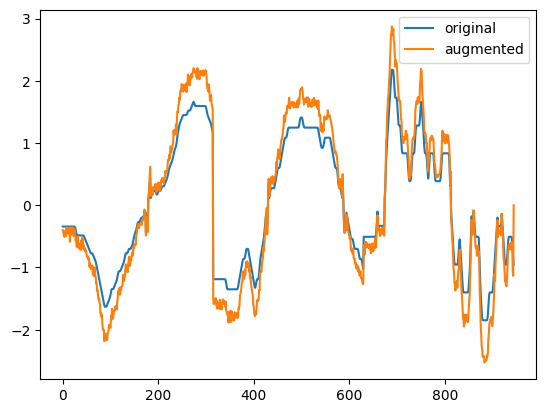

In [41]:
config = load_yaml_param_settings("configs/config.yaml")

dataset_name = "UWaveGestureLibraryAll"
config['dataset']['dataset_name'] = dataset_name

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader_aug = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True,
)
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=False
)

test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])
for batch in train_data_loader_aug:
    x_original, xaug, y = batch
    break

plt.plot(x_original[0, 0], label="original")
plt.plot(xaug[0, 0], label="augmented")
plt.legend()
plt.savefig(dataset_name + "_augmentation.png")
plt.show()

In [42]:
split_size = int(0.2 * dataset_importer.X_train.shape[1])
print(split_size)
cropped_aug = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True, split_size=split_size
)

189


In [43]:
from experiments.exp_vqvae import Exp_VQVAE

input_length = train_data_loader.dataset.X.shape[-1]
config["SSL"]["stage1_method"] = ""
input

train_exp = Exp_VQVAE(
    split_size,
    config=config,
    n_train_samples=len(train_data_loader.dataset),
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
)
encoder = train_exp.encoder

In [70]:
for batch in cropped_aug:
    x_orig, x_aug, y = batch
    x_orig = torch.transpose(x_orig, 1, 0)
    x_aug = torch.transpose(x_aug, 1, 0)
    break

In [56]:
x_aug = torch.randperm(x_aug.shape[0])

In [82]:
x = torch.transpose(x_orig, 0, 1)
x = x.view(x.shape[0], -1).unsqueeze(1)
x.shape

torch.Size([128, 1, 945])

In [55]:
C = x_orig.shape[2]

def encode_cropped_views(x_crops, n_fft):
    C = x_crops.shape[2]
    u_list = [time_to_timefreq(x, n_fft, C) for x in x_crops]
    z = [encoder(u) for u in u_list]
    return z

z = encode_cropped_views(x_orig, 8)
z = torch.stack(z)
z = z.reshape(z.shape[1], z.shape[0], z.shape[2], -1)
print(z.shape)

torch.Size([128, 5, 64, 55])


In [50]:
print(n_splits)

189


In [49]:
u = time_to_timefreq(x_original, 8, C)
z = encoder(u)
print(z.shape)

torch.Size([128, 64, 5, 59])


In [6]:

X = dataset_importer.X_train
x = X[0]

# Calculate the number of splits and the split size
n_splits = int(0.2 * x.shape[0])
split_size = x.shape[0] // n_splits

if np.random.rand() < 0.5:
    x = x[:split_size * n_splits]
else:
    start = x.shape[0] - split_size * n_splits
    x = x[start:]

# Split the array into equally sized chunks
x_splits = np.array_split(x, split_size, axis=0)

# Print the size of each split
for split in x_splits:
    print(split.shape)

(189,)
(189,)
(189,)
(189,)
(189,)


(896, 945)


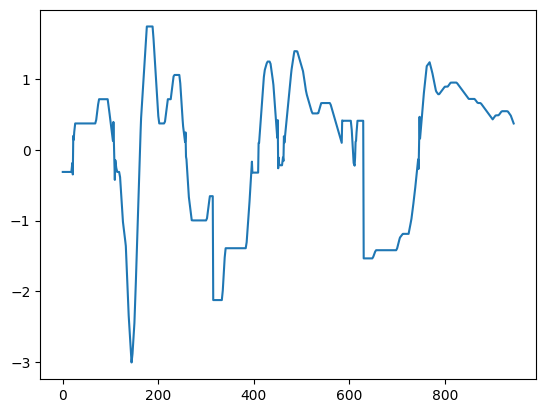

(189,)


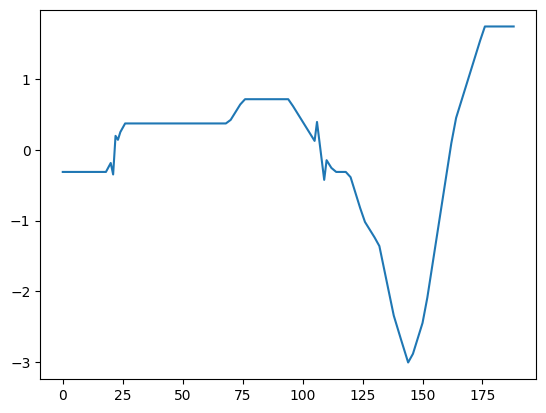

(189,)


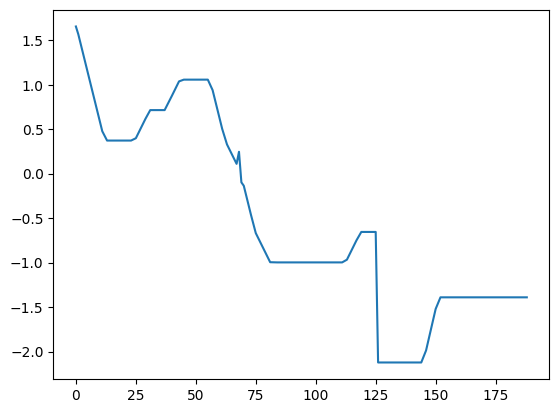

(189,)


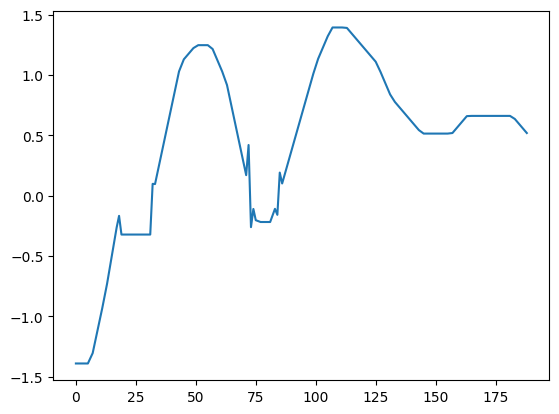

(189,)


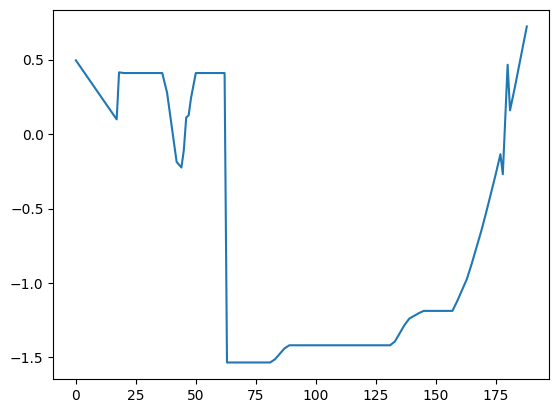

(189,)


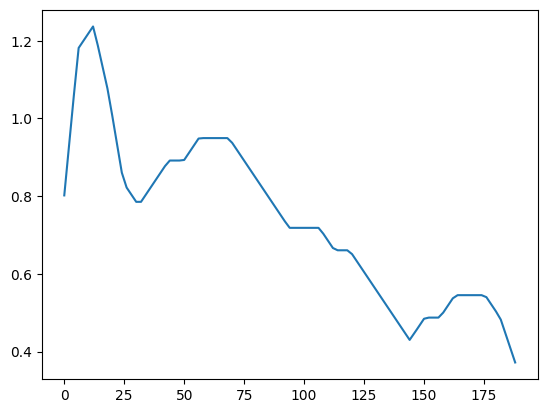

In [7]:
X = dataset_importer.X_train
x = X[0]
print(X.shape)

split_size = int(0.2 * x.shape[0])  # Ensure split_size is an integer
n_splits = x.shape[0] // split_size
if x.shape[0] % split_size != 0:
    n_splits += 1

x_splits = np.array_split(x, n_splits, axis=0)

# Ensure each split has the same size
for i in range(len(x_splits)):
    if len(x_splits[i]) < split_size:
        diff = split_size - len(x_splits[i])
        x_splits[i] = np.concatenate((x_splits[i-1][-diff:], x_splits[i]))

plt.plot(x)
plt.show()
for i in range(n_splits):
    plt.plot(x_splits[i])
    print(x_splits[i].shape)
    plt.show()

In [123]:
x, xaug = x_batch

u = time_to_timefreq(x, config["VQVAE"]["n_fft"], x.shape[1])
u_aug = time_to_timefreq(xaug, config["VQVAE"]["n_fft"], x.shape[1])
z_1 = encoder(u)
z_2 = encoder(u_aug)

In [106]:
print(x.shape)

torch.Size([128, 1, 945])


In [124]:
def random_crop(*subx_views):
    """
    Apply random cropping to input sequences based on self.window_ratio.

    Parameters:
    - subx_views: Variable number of input sequences (batch_size, channels, subseq_len).

    Returns:
    - cropped_views: List of cropped sequences.
    """

    cropped_views = []
    for subx in subx_views:
        subseq_len = subx.shape[-1]
        crop_size = int(0.5 * subseq_len)  # Calculate crop size based on self.window_ratio
        start_idx = np.random.randint(0, subseq_len - crop_size + 1)  # Generate a random start index for the crop
        cropped_view = subx[:, :, start_idx:start_idx + crop_size]  # Use slicing to crop the subx_view

        cropped_views.append(cropped_view)

    if len(cropped_views) == 1:
        cropped_views = cropped_views[0]

    return cropped_views

def random_crop(self, *x_views):
    subx_views = []
    rand_ts = []
    subseq_len = 10
    for i in range(len(x_views)):
        seq_len = x_views[i].shape[-1]
        rand_t = np.random.randint(0, seq_len - subseq_len + 1, size=1)[0]
        subx = x_views[i][:, rand_t: rand_t + subseq_len]  # (subseq_len)
        subx_views.append(subx)
        rand_ts.append(rand_t)

    if len(subx_views) == 1:
        subx_views = subx_views[0]
    return subx_views

TypeError: list indices must be integers or slices, not tuple

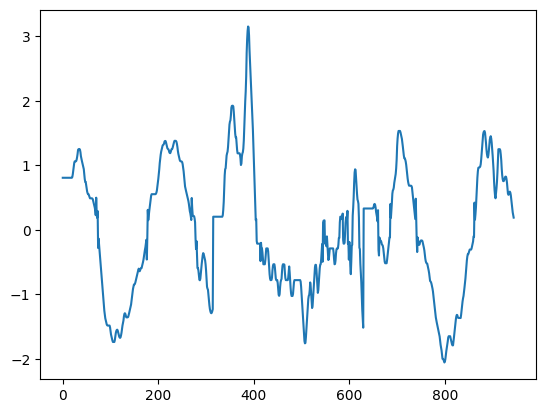

In [139]:


xaug = random_crop(xaug, 10)
plt.plot(x[0, 0])
plt.plot(xaug[0, 0])


In [136]:
def random_crop(self, subseq_len: int, *x_views):
    subx_views = []
    rand_ts = []
    for i in range(len(x_views)):
        seq_len = x_views[i].shape[-1]
        rand_t = np.random.randint(0, seq_len - subseq_len + 1, size=1)[0]
        subx = x_views[i][:, rand_t: rand_t + subseq_len]  # (subseq_len)
        subx_views.append(subx)
        rand_ts.append(rand_t)

    if len(subx_views) == 1:
        subx_views = subx_views[0]
    return subx_views

TypeError: list indices must be integers or slices, not tuple

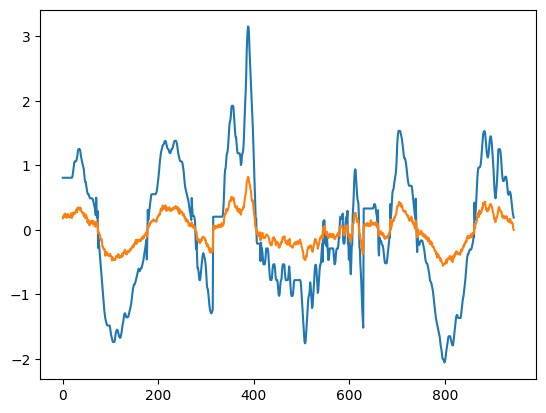

In [137]:
for batch in train_data_loader_aug:
    x_batch, y = batch
    break

x, xaug = x_batch
xaug_cropped = random_crop(xaug, 10)

plt.plot(x[0, 0])
plt.plot(xaug[0, 0])
plt.plot(xaug_cropped[0, 0])

u1 = time_to_timefreq(x, config["VQVAE"]["n_fft"], x.shape[1])
uaug = time_to_timefreq(xaug_cropped, config["VQVAE"]["n_fft"], x.shape[1])

z1 = encoder(u1)
z2 = encoder(uaug)





In [16]:
from experiments.exp_vqvae import Exp_VQVAE

input_length = train_data_loader.dataset.X.shape[-1]
config["SSL"]["stage1_method"] = ""
input

train_exp = Exp_VQVAE(
    input_length,
    config=config,
    n_train_samples=len(train_data_loader.dataset),
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
)
encoder = train_exp.encoder